In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler,MinMaxScaler

import warnings
warnings.filterwarnings("ignore")
# import time
import pickle
import json

In [2]:
# start = time.time()

# Load DataSet:
df = pd.read_csv("diabetes.csv")
df.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,148,50,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
2,183,64,0,0,23.3,0.672,52,1
3,150,66,23,94,28.1,0.167,21,0
4,150,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Glucose                   768 non-null    int64  
 1   BloodPressure             768 non-null    int64  
 2   SkinThickness             768 non-null    int64  
 3   Insulin                   768 non-null    int64  
 4   BMI                       768 non-null    float64
 5   DiabetesPedigreeFunction  768 non-null    float64
 6   Age                       768 non-null    int64  
 7   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 48.1 KB


In [4]:
#Split data:

x = df.drop("Outcome",axis=1)
y = df["Outcome"]

In [5]:
# We will save different model performanes:

Model_Performanece ={
    "Model_Description":[],
    "k_neighbour":[],
    "p":[],
    "Training_Accuracy":[],
    "Testing_Accuracy":[],
    
    
}

In [6]:
# Function for training the KNN_classifier model and geting evalation metrics:
def train_n_Evaluate_model(x,y,K,P,model_desc,scaling_Obj=None ):
    '''This fuction returns a tuple having model at zeroth index,
       tuple of evalation metrics for traing data at index one,
       another tuple having evaluation metrics for testing data at index two,
       at last index input data: (x,y)
       
       returns:
       ((knn_clf,scaling_Obj),(accuracy_train,Clf_report_train,Conf_matrix_train),(accuracy_test,Clf_report_test,Conf_matrix_test),(x,y))'''
    
    #Split training and testing data:
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=2,stratify=y)
    
    
    # Builting and traning the model:
    knn_clf = KNeighborsClassifier(n_neighbors=K,p=P)
    knn_clf.fit(x_train,y_train)
    
    #Prediction on testin and training data:
    y_pred_train = knn_clf.predict(x_train)
    y_pred_test = knn_clf.predict(x_test)
    
    #Finding training and testing accuracy:
    accuracy_train  = accuracy_score(y_train,y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    
    #Classification Report:
    Clf_report_train = classification_report(y_train, y_pred_train)
    Clf_report_test = classification_report(y_test, y_pred_test)
    
    #Confusion Matrix:
    Conf_matrix_train = confusion_matrix(y_train, y_pred_train)
    Conf_matrix_test = confusion_matrix(y_test, y_pred_test)
    
    #Inserting model data and details into a dictionary: Model_Performanece
    global Model_Performanece
    model_data = [model_desc,K,P,accuracy_train,accuracy_test]
    for i, data_list in enumerate(Model_Performanece.values()):
        data_list.append(model_data[i])
        
    
    return (knn_clf,scaling_Obj),(accuracy_train,Clf_report_train,Conf_matrix_train),(accuracy_test,Clf_report_test,Conf_matrix_test),(x,y)

In [7]:
# Saving model data (model,training evaluation data, testing evaluation data):
Model_1 = train_n_Evaluate_model(x,y,5,2,"KNN_Clf")

print("Without Scaling,without Removing outliers,without hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_1[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_1[2][0]
print("Testing accuracy",Testing_accuracy)

Without Scaling,without Removing outliers,without hyperparam tuning:

Training accuracy 0.8020833333333334
Testing accuracy 0.734375


### Not good results by the model.

# HyperParameter Tuning:

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=2,stratify=y)

knnclf = KNeighborsClassifier()
hyperparameter = {"n_neighbors":np.arange(3,31),
                  "p":[1,2]}

gscv_knnclf = GridSearchCV(knnclf,hyperparameter,cv=5)
gscv_knnclf.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                         'p': [1, 2]})

In [9]:
gscv_knnclf.best_estimator_

KNeighborsClassifier(n_neighbors=15, p=1)

In [10]:
Model_2 = train_n_Evaluate_model(x,y,15,1,"KNN_Clf, HyperParm")

print("Without Scaling,without Removing outliers,with hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_2[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_2[2][0]
print("Testing accuracy",Testing_accuracy)

Without Scaling,without Removing outliers,with hyperparam tuning:

Training accuracy 0.7847222222222222
Testing accuracy 0.7135416666666666


# Scale the data using Normalization:

In [11]:
df.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,148,50,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
2,183,64,0,0,23.3,0.672,52,1
3,150,66,23,94,28.1,0.167,21,0
4,150,40,35,168,43.1,2.288,33,1


In [12]:
normal_scalar = MinMaxScaler()

In [13]:
x,y = df.drop("Outcome",axis=1),df.Outcome
x = pd.DataFrame(normal_scalar.fit_transform(x),columns=x.columns)
x

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.743719,0.409836,0.353535,0.000000,0.500745,0.234415,0.483333
1,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667
2,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.516667
3,0.753769,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000
4,0.753769,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000
...,...,...,...,...,...,...,...
763,0.507538,0.622951,0.484848,0.212766,0.490313,0.039710,0.700000
764,0.613065,0.573770,0.272727,0.000000,0.548435,0.111870,0.100000
765,0.608040,0.590164,0.232323,0.132388,0.390462,0.071307,0.150000
766,0.633166,0.491803,0.000000,0.000000,0.448584,0.115713,0.433333


In [14]:
Model_3 = train_n_Evaluate_model(x,y,5,2,"KNN_Clf, Nml_scaling",normal_scalar)

print("With Normalization Scaling,without Removing outliers,without Hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_3[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_3[2][0]
print("Testing accuracy",Testing_accuracy)

With Normalization Scaling,without Removing outliers,without Hyperparam tuning:

Training accuracy 0.8020833333333334
Testing accuracy 0.7135416666666666


# Hyperparameter Tuning on model of normalized dataset:

In [15]:
knnclf = KNeighborsClassifier()
hyperparameter = {"n_neighbors":np.arange(3,31),
                  "p":[1,2]}

gscv_knnclf = GridSearchCV(knnclf,hyperparameter,cv=5)
gscv_knnclf.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                         'p': [1, 2]})

In [16]:
gscv_knnclf.best_estimator_

KNeighborsClassifier(n_neighbors=15, p=1)

In [17]:
Model_4 = train_n_Evaluate_model(x,y,20,1,"KNN_Clf, Nml_scaling, Hyperparam_tune",normal_scalar)

print("Without Scaling,without Removing outliers,with hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_4[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_4[2][0]
print("Testing accuracy",Testing_accuracy)

Without Scaling,without Removing outliers,with hyperparam tuning:

Training accuracy 0.78125
Testing accuracy 0.734375


# Scale the data using Standarization:

In [18]:
x,y = df.drop("Outcome",axis=1),df.Outcome
std_scale = StandardScaler()
x = pd.DataFrame(std_scale.fit_transform(x),columns=x.columns)

In [19]:
x.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.845787,-0.985618,0.907270,-0.692891,0.204013,0.468492,1.426022
1,-1.136319,-0.158966,0.530902,-0.692891,-0.684422,-0.365061,-0.190927
2,1.946957,-0.262298,-1.288212,-0.692891,-1.103255,0.604397,1.596227
3,0.908711,-0.158966,0.154533,0.123302,-0.494043,-0.920763,-1.041953
4,0.908711,-1.502276,0.907270,0.765836,1.409746,5.484909,-0.020722


In [20]:
Model_5 = train_n_Evaluate_model(x,y,5,2,"KNN_Clf, std_scaling",std_scale)

print("With Standarization Scaling Method,without Removing outliers,without hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_5[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_5[2][0]
print("Testing accuracy",Testing_accuracy)

With Standarization Scaling Method,without Removing outliers,without hyperparam tuning:

Training accuracy 0.7951388888888888
Testing accuracy 0.7083333333333334


# Hyperparameter Tuning on model of Standarized dataset:

In [21]:
knnclf = KNeighborsClassifier()
hyperparameter = {"n_neighbors":np.arange(3,31),
                  "p":[1,2]}

gscv_knnclf = GridSearchCV(knnclf,hyperparameter,cv=5)
gscv_knnclf.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                         'p': [1, 2]})

In [22]:
gscv_knnclf.best_estimator_

KNeighborsClassifier(n_neighbors=15, p=1)

In [23]:
Model_6 = train_n_Evaluate_model(x,y,15,1,"KNN_Clf, Stand_scaling, Hyperparam_tune",std_scale)

print("With Standarization Scaling Method,without Removing outliers,with hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_6[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_6[2][0]
print("Testing accuracy",Testing_accuracy)

With Standarization Scaling Method,without Removing outliers,with hyperparam tuning:

Training accuracy 0.7881944444444444
Testing accuracy 0.75


In [24]:
print("Performances:  KNN_clf on Diabetes Dataset Without Handling Outliers")
performance = pd.DataFrame(Model_Performanece)
performance

Performances:  KNN_clf on Diabetes Dataset Without Handling Outliers


,Model_Description,k_neighbour,p,Training_Accuracy,Testing_Accuracy
0,KNN_Clf,5,2,0.802083,0.734375
1,"KNN_Clf, HyperParm",15,1,0.784722,0.713542
2,"KNN_Clf, Nml_scaling",5,2,0.802083,0.713542
3,"KNN_Clf, Nml_scaling, Hyperparam_tune",20,1,0.781250,0.734375
4,"KNN_Clf, std_scaling",5,2,0.795139,0.708333
5,"KNN_Clf, Stand_scaling, Hyperparam_tune",15,1,0.788194,0.750000


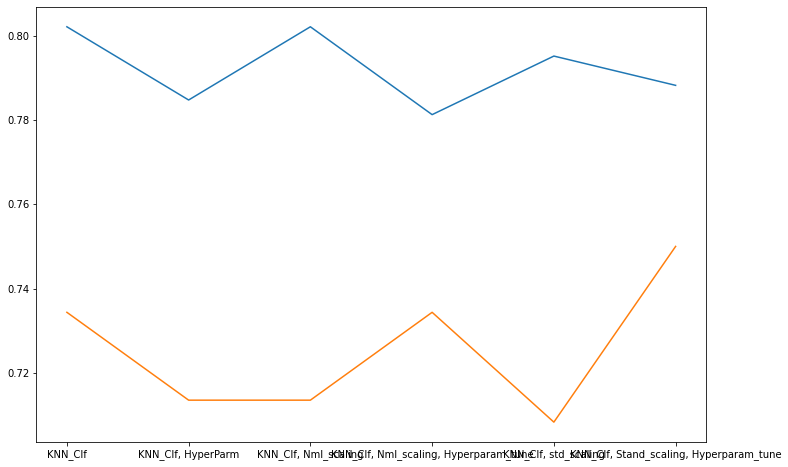

In [25]:
performance
plt.figure(figsize=(12,8))
plt.plot(performance.Model_Description,performance.Training_Accuracy)
plt.plot(performance.Model_Description,performance.Testing_Accuracy)

In [26]:
print("*"*248)

********************************************************************************************************************************************************************************************************************************************************


# Handling Outlier:

In [27]:
df_copy = df.drop("Outcome",axis=1).copy()
df_copy

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,148,50,35,0,33.6,0.627,50
1,85,66,29,0,26.6,0.351,31
2,183,64,0,0,23.3,0.672,52
3,150,66,23,94,28.1,0.167,21
4,150,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...
763,101,76,48,180,32.9,0.171,63
764,122,70,27,0,36.8,0.340,27
765,121,72,23,112,26.2,0.245,30
766,126,60,0,0,30.1,0.349,47


In [28]:
df.describe()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,121.117188,69.076823,20.536458,79.799479,31.992578,0.471876,33.243490,0.348958
std,31.805091,19.367794,15.952218,115.244002,7.884160,0.331329,11.758182,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,142.000000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [29]:
def cap_outliers(dataframe,cols,thre):
    for col in cols:
        
        mean = dataframe[col].mean()
        std = dataframe[col].std()
        uppr_bound = mean + thre*std
        lowr_bound = mean - thre*std
        
        dataframe[col] = np.where(dataframe[col]>uppr_bound,uppr_bound,
                                  np.where(dataframe[col]<lowr_bound,lowr_bound,
                                           dataframe[col]))
        return dataframe

In [30]:
df_copy = df_copy[~((df_copy["Glucose"]==0) & (df_copy["Insulin"]==0))]

In [31]:
df_copy

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,148,50,35,0,33.6,0.627,50
1,85,66,29,0,26.6,0.351,31
2,183,64,0,0,23.3,0.672,52
3,150,66,23,94,28.1,0.167,21
4,150,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...
763,101,76,48,180,32.9,0.171,63
764,122,70,27,0,36.8,0.340,27
765,121,72,23,112,26.2,0.245,30
766,126,60,0,0,30.1,0.349,47


In [32]:
df_copy = df_copy[~((df_copy["SkinThickness"]==0) & (df_copy["Insulin"]==0))]
df_copy

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,148,50,35,0,33.6,0.627,50
1,85,66,29,0,26.6,0.351,31
3,150,66,23,94,28.1,0.167,21
4,150,40,35,168,43.1,2.288,33
6,150,50,32,88,31.0,0.248,26
...,...,...,...,...,...,...,...
761,170,74,31,0,44.0,0.403,43
763,101,76,48,180,32.9,0.171,63
764,122,70,27,0,36.8,0.340,27
765,121,72,23,112,26.2,0.245,30


In [33]:
df_copy.describe()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,120.797020,71.195531,29.132216,114.126629,32.763687,0.505628,31.532588
std,31.026195,13.042730,10.492322,122.800738,7.148427,0.347335,10.718731
min,0.000000,0.000000,7.000000,0.000000,0.000000,0.085000,21.000000
25%,99.000000,64.000000,22.000000,0.000000,27.800000,0.259000,23.000000
50%,116.000000,72.000000,29.000000,90.000000,32.800000,0.419000,28.000000
75%,142.000000,80.000000,36.000000,165.000000,36.900000,0.660000,38.000000
max,199.000000,110.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [34]:
df_copy = cap_outliers(df_copy,df_copy.columns,3)

In [35]:
df_copy.describe()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,120.848638,71.195531,29.132216,114.126629,32.763687,0.505628,31.532588
std,30.847396,13.042730,10.492322,122.800738,7.148427,0.347335,10.718731
min,27.718436,0.000000,7.000000,0.000000,0.000000,0.085000,21.000000
25%,99.000000,64.000000,22.000000,0.000000,27.800000,0.259000,23.000000
50%,116.000000,72.000000,29.000000,90.000000,32.800000,0.419000,28.000000
75%,142.000000,80.000000,36.000000,165.000000,36.900000,0.660000,38.000000
max,199.000000,110.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [36]:
for col in df_copy.columns:
    print((df_copy[col]==0).sum())
    

0
2
0
143
2
0
0


In [37]:
df_copy = df_copy.drop("Insulin",axis=1)

In [38]:
df_copy

,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age
0,148.0,50,35,33.6,0.627,50
1,85.0,66,29,26.6,0.351,31
3,150.0,66,23,28.1,0.167,21
4,150.0,40,35,43.1,2.288,33
6,150.0,50,32,31.0,0.248,26
...,...,...,...,...,...,...
761,170.0,74,31,44.0,0.403,43
763,101.0,76,48,32.9,0.171,63
764,122.0,70,27,36.8,0.340,27
765,121.0,72,23,26.2,0.245,30


In [39]:
df_copy

,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age
0,148.0,50,35,33.6,0.627,50
1,85.0,66,29,26.6,0.351,31
3,150.0,66,23,28.1,0.167,21
4,150.0,40,35,43.1,2.288,33
6,150.0,50,32,31.0,0.248,26
...,...,...,...,...,...,...
761,170.0,74,31,44.0,0.403,43
763,101.0,76,48,32.9,0.171,63
764,122.0,70,27,36.8,0.340,27
765,121.0,72,23,26.2,0.245,30


In [40]:
df_copy.min()

Glucose                     27.718436
BloodPressure                0.000000
SkinThickness                7.000000
BMI                          0.000000
DiabetesPedigreeFunction     0.085000
Age                         21.000000
dtype: float64

In [41]:
df_copy = df_copy[df_copy.BloodPressure != 0]
df_copy = df_copy[df_copy.DiabetesPedigreeFunction != 0]
df_copy = df_copy[df_copy.BMI != 0]

In [42]:
df_copy.describe()

,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age
count,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000
mean,120.937558,71.469043,29.165103,32.880488,0.502583,31.560976
std,30.915157,12.334372,10.521502,6.878314,0.344336,10.722163
min,27.718436,24.000000,7.000000,18.200000,0.085000,21.000000
25%,99.000000,64.000000,22.000000,27.800000,0.259000,23.000000
50%,116.000000,72.000000,29.000000,32.800000,0.415000,28.000000
75%,142.000000,80.000000,36.000000,36.900000,0.658000,38.000000
max,199.000000,110.000000,99.000000,67.100000,2.420000,81.000000


In [43]:
x = df_copy.copy()
y = df.Outcome.iloc[df_copy.index]

In [44]:
Model_7 = train_n_Evaluate_model(x,y,5,2,"KNN_Clf, Outlier_Handled")

print("Without Scaling,handle outliers,without hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_7[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_7[2][0]
print("Testing accuracy",Testing_accuracy)

Without Scaling,handle outliers,without hyperparam tuning:

Training accuracy 0.8320802005012531
Testing accuracy 0.7313432835820896


# HyperParameter Tuning:

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=2,stratify=y)

knnclf = KNeighborsClassifier()
hyperparameter = {"n_neighbors":np.arange(3,31),
                  "p":[1,2]}

gscv_knnclf = GridSearchCV(knnclf,hyperparameter,cv=5)
gscv_knnclf.fit(x_train,y_train)

gscv_knnclf.best_estimator_

KNeighborsClassifier(n_neighbors=27, p=1)

In [46]:
Model_8 = train_n_Evaluate_model(x,y,27,1,"KNN_Clf, Outlier_Handled, Hyperparam_tune")

print("Without Scaling,handle outliers,with hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_8[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_8[2][0]
print("Testing accuracy",Testing_accuracy)

Without Scaling,handle outliers,with hyperparam tuning:

Training accuracy 0.7919799498746867
Testing accuracy 0.7313432835820896


# Scale the data using Normalization:

In [47]:
normal_scalar = MinMaxScaler()
x = df_copy.copy()
x = pd.DataFrame(normal_scalar.fit_transform(x),columns=x.columns)
x

,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age
0,0.702245,0.302326,0.304348,0.314928,0.232120,0.483333
1,0.334429,0.488372,0.239130,0.171779,0.113919,0.166667
2,0.713921,0.488372,0.173913,0.202454,0.035118,0.000000
3,0.713921,0.186047,0.304348,0.509202,0.943469,0.200000
4,0.713921,0.302326,0.271739,0.261759,0.069807,0.083333
...,...,...,...,...,...,...
528,0.830688,0.581395,0.260870,0.527607,0.136188,0.366667
529,0.427843,0.604651,0.445652,0.300613,0.036831,0.700000
530,0.550448,0.534884,0.217391,0.380368,0.109208,0.100000
531,0.544609,0.558140,0.173913,0.163599,0.068522,0.150000


In [48]:
Model_9 = train_n_Evaluate_model(x,y,5,2,"KNN_Clf, Outlier_Handled, Norm_scaling",normal_scalar)

print("With Normalization Scaling,handled outliers,without Hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_9[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_9[2][0]
print("Testing accuracy",Testing_accuracy)

With Normalization Scaling,handled outliers,without Hyperparam tuning:

Training accuracy 0.8195488721804511
Testing accuracy 0.7611940298507462


# Hyperparameter Tuning on model of normalized dataset:

In [49]:
knnclf = KNeighborsClassifier()
hyperparameter = {"n_neighbors":np.arange(3,31),
                  "p":[1,2]}

gscv_knnclf = GridSearchCV(knnclf,hyperparameter,cv=5)
gscv_knnclf.fit(x_train,y_train)

gscv_knnclf.best_estimator_

KNeighborsClassifier(n_neighbors=27, p=1)

In [50]:
Model_10 = train_n_Evaluate_model(x,y,27,1,"KNN_Clf, Outlier_Handled, Norm_scaling, Hyperparam_tuning",normal_scalar)

print("Without Scaling,handled outliers,with hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_10[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_10[2][0]
print("Testing accuracy",Testing_accuracy)

Without Scaling,handled outliers,with hyperparam tuning:

Training accuracy 0.7969924812030075
Testing accuracy 0.746268656716418


# Scale the data using Standarization:

In [51]:
x = df_copy.copy()
std_scale = StandardScaler()
x = pd.DataFrame(std_scale.fit_transform(x),columns=x.columns)

In [52]:
Model_11 = train_n_Evaluate_model(x,y,5,2,"KNN_Clf, Outlier_Handled, Std_scaling",std_scale)

print("With Standarization Scaling Method,without Removing outliers,without hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_11[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_11[2][0]
print("Testing accuracy",Testing_accuracy)

With Standarization Scaling Method,without Removing outliers,without hyperparam tuning:

Training accuracy 0.8145363408521303
Testing accuracy 0.7388059701492538


# Hyperparameter Tuning on model of Standarized dataset:

In [53]:
knnclf = KNeighborsClassifier()
hyperparameter = {"n_neighbors":np.arange(3,31),
                  "p":[1,2]}

gscv_knnclf = GridSearchCV(knnclf,hyperparameter,cv=5)
gscv_knnclf.fit(x_train,y_train)

gscv_knnclf.best_estimator_

KNeighborsClassifier(n_neighbors=27, p=1)

In [54]:
Model_12 = train_n_Evaluate_model(x,y,27,1,"KNN_Clf, Outlier_Handled, Std_scaling, Hyperparam_tuning",std_scale)

print("With Standarization Scaling Method,without Removing outliers,with hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_12[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_12[2][0]
print("Testing accuracy",Testing_accuracy)

With Standarization Scaling Method,without Removing outliers,with hyperparam tuning:

Training accuracy 0.7969924812030075
Testing accuracy 0.746268656716418


In [55]:
print("*"*248)

********************************************************************************************************************************************************************************************************************************************************


# Replace all zeros with mean of remaining data in perticular column:

In [56]:
df

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,148,50,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
2,183,64,0,0,23.3,0.672,52,1
3,150,66,23,94,28.1,0.167,21,0
4,150,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...
763,101,76,48,180,32.9,0.171,63,0
764,122,70,27,0,36.8,0.340,27,0
765,121,72,23,112,26.2,0.245,30,0
766,126,60,0,0,30.1,0.349,47,1


In [57]:
df2 = df.copy()
df2

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,148,50,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
2,183,64,0,0,23.3,0.672,52,1
3,150,66,23,94,28.1,0.167,21,0
4,150,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...
763,101,76,48,180,32.9,0.171,63,0
764,122,70,27,0,36.8,0.340,27,0
765,121,72,23,112,26.2,0.245,30,0
766,126,60,0,0,30.1,0.349,47,1


In [58]:
def replace_zerowith_null(x):
    if x == 0:
        return np.nan
    else:
        return x

In [59]:
x = df2.drop("Outcome", axis=1)
y = df.Outcome

In [60]:
for col in x.columns:
    x[col] = x[col].apply(replace_zerowith_null)

x

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,148.0,50.0,35.0,NaN,33.6,0.627,50
1,85.0,66.0,29.0,NaN,26.6,0.351,31
2,183.0,64.0,NaN,NaN,23.3,0.672,52
3,150.0,66.0,23.0,94.0,28.1,0.167,21
4,150.0,40.0,35.0,168.0,43.1,2.288,33
...,...,...,...,...,...,...,...
763,101.0,76.0,48.0,180.0,32.9,0.171,63
764,122.0,70.0,27.0,NaN,36.8,0.340,27
765,121.0,72.0,23.0,112.0,26.2,0.245,30
766,126.0,60.0,NaN,NaN,30.1,0.349,47


In [61]:
def replaceNullWithMean(dataframe,col):
    dataframe[col] = dataframe[col].fillna(dataframe[col].mean(skipna = True))

In [62]:
for col in x.columns:
    replaceNullWithMean(x,col)

In [63]:
x_original = x.copy()

In [64]:
x

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,148.0,50.0,35.00000,155.548223,33.6,0.627,50
1,85.0,66.0,29.00000,155.548223,26.6,0.351,31
2,183.0,64.0,29.15342,155.548223,23.3,0.672,52
3,150.0,66.0,23.00000,94.000000,28.1,0.167,21
4,150.0,40.0,35.00000,168.000000,43.1,2.288,33
...,...,...,...,...,...,...,...
763,101.0,76.0,48.00000,180.000000,32.9,0.171,63
764,122.0,70.0,27.00000,155.548223,36.8,0.340,27
765,121.0,72.0,23.00000,112.000000,26.2,0.245,30
766,126.0,60.0,29.15342,155.548223,30.1,0.349,47


In [65]:
# 13>

Model_13 = train_n_Evaluate_model(x,y,5,2,"KNN_Clf, Outlier_Handled")

print("Without Scaling,handle outliers,without hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_13[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_13[2][0]
print("Testing accuracy",Testing_accuracy)

Without Scaling,handle outliers,without hyperparam tuning:

Training accuracy 0.8072916666666666
Testing accuracy 0.7291666666666666


In [66]:
# 14>

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=2,stratify=y)

knnclf = KNeighborsClassifier()
hyperparameter = {"n_neighbors":np.arange(3,31),
                  "p":[1,2]}

gscv_knnclf = GridSearchCV(knnclf,hyperparameter,cv=5)
gscv_knnclf.fit(x_train,y_train)

gscv_knnclf.best_estimator_

KNeighborsClassifier(n_neighbors=25)

In [67]:
Model_14= train_n_Evaluate_model(x,y,25,2,"KNN_Clf, Outlier_Handled, Hyperparam_tune")

print("Without Scaling,handle outliers,with hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_14[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_14[2][0]
print("Testing accuracy",Testing_accuracy)

Without Scaling,handle outliers,with hyperparam tuning:

Training accuracy 0.765625
Testing accuracy 0.71875


In [68]:
# 15> Normalization techniqu on data for scaling:

normal_scalar = MinMaxScaler()
x = x_original.copy()
x = pd.DataFrame(normal_scalar.fit_transform(x),columns=x.columns)

In [69]:
Model_15 = train_n_Evaluate_model(x,y,5,2,"KNN_Clf, Outlier_Handled, Norm_scaling",normal_scalar)

print("With Normalization Scaling,handled outliers,without Hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_15[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_15[2][0]
print("Testing accuracy",Testing_accuracy)

With Normalization Scaling,handled outliers,without Hyperparam tuning:

Training accuracy 0.8229166666666666
Testing accuracy 0.7395833333333334


In [70]:
# 16> Normalization techniqu on data for scaling and tune hyper_parameter:

knnclf = KNeighborsClassifier()
hyperparameter = {"n_neighbors":np.arange(3,31),
                  "p":[1,2]}

gscv_knnclf = GridSearchCV(knnclf,hyperparameter,cv=5)
gscv_knnclf.fit(x_train,y_train)

gscv_knnclf.best_estimator_

KNeighborsClassifier(n_neighbors=25)

In [71]:
Model_16 = train_n_Evaluate_model(x,y,25,2,"KNN_Clf, Outlier_Handled, Norm_scaling, Hyperparam_tuning",normal_scalar)

print("Without Scaling,handled outliers,with hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_16[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_16[2][0]
print("Testing accuracy",Testing_accuracy)

Without Scaling,handled outliers,with hyperparam tuning:

Training accuracy 0.8020833333333334
Testing accuracy 0.7916666666666666


In [72]:
# 17> Std techniqu on data for scaling :

x = x_original.copy()
std_scale = StandardScaler()
x = pd.DataFrame(std_scale.fit_transform(x),columns=x.columns)

In [73]:
Model_17 = train_n_Evaluate_model(x,y,5,2,"KNN_Clf, Outlier_Handled, Std_scaling",std_scale)

print("With Standarization Scaling Method,without Removing outliers,without hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_17[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_17[2][0]
print("Testing accuracy",Testing_accuracy)

With Standarization Scaling Method,without Removing outliers,without hyperparam tuning:

Training accuracy 0.8038194444444444
Testing accuracy 0.7395833333333334


In [74]:
# 18> Normalization techniqu on data for scaling and tune hyper_parameter:

knnclf = KNeighborsClassifier()
hyperparameter = {"n_neighbors":np.arange(3,31),
                  "p":[1,2]}

gscv_knnclf = GridSearchCV(knnclf,hyperparameter,cv=5)
gscv_knnclf.fit(x_train,y_train)
gscv_knnclf.best_estimator_

KNeighborsClassifier(n_neighbors=25)

In [75]:
Model_18 = train_n_Evaluate_model(x,y,25,2,"KNN_Clf, Outlier_Handled, Std_scaling, Hyperparam_tuning",std_scale)

print("With Standarization Scaling Method,without Removing outliers,with hyperparam tuning:\n")
# Printing Traing and Testing Accuracy:
Training_accuracy = Model_18[1][0]
print("Training accuracy",Training_accuracy)
Testing_accuracy = Model_18[2][0]
print("Testing accuracy",Testing_accuracy)

With Standarization Scaling Method,without Removing outliers,with hyperparam tuning:

Training accuracy 0.8020833333333334
Testing accuracy 0.7916666666666666


In [76]:
performance=pd.DataFrame(Model_Performanece)
performance

,Model_Description,k_neighbour,p,Training_Accuracy,Testing_Accuracy
0,KNN_Clf,5,2,0.802083,0.734375
1,"KNN_Clf, HyperParm",15,1,0.784722,0.713542
2,"KNN_Clf, Nml_scaling",5,2,0.802083,0.713542
3,"KNN_Clf, Nml_scaling, Hyperparam_tune",20,1,0.781250,0.734375
4,"KNN_Clf, std_scaling",5,2,0.795139,0.708333
5,"KNN_Clf, Stand_scaling, Hyperparam_tune",15,1,0.788194,0.750000
6,"KNN_Clf, Outlier_Handled",5,2,0.832080,0.731343
7,"KNN_Clf, Outlier_Handled, Hyperparam_tune",27,1,0.791980,0.731343
8,"KNN_Clf, Outlier_Handled, Norm_scaling",5,2,0.819549,0.761194
9,"KNN_Clf, Outlier_Handled, Norm_scaling, Hyperp...",27,1,0.796992,0.746269


In [77]:
# end = time.time()
# total_time = end - start
# print(total_time)

# We have selected model_18 as a best model which have:

   - data scaling with standarization technique 
   - all zeros in a column, replaced by mean of that perticular column 
   - hyperparameter tuning performed : k_neighbour = 25, p = 2

In [78]:
model = Model_18[0][0]
scaling_obj = Model_18[0][1]
x = Model_18[-1][0]
y = Model_18[-1][1]

In [79]:
print("Model:")
model

Model:


KNeighborsClassifier(n_neighbors=25)

In [80]:
print("Scaling Object:")
scaling_obj

Scaling Object:


StandardScaler()

In [81]:
print("Scaled Features:")
x

Scaled Features:


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.862896,-1.846833,6.655021e-01,-3.345079e-16,0.166292,0.468492,1.426022
1,-1.220825,-0.526203,-1.746338e-02,-3.345079e-16,-0.852531,-0.365061,-0.190927
2,2.020519,-0.691281,8.087936e-16,-3.345079e-16,-1.332833,0.604397,1.596227
3,0.929046,-0.526203,-7.004289e-01,-7.243887e-01,-0.634212,-0.920763,-1.041953
4,0.929046,-2.672226,6.655021e-01,1.465506e-01,1.548980,5.484909,-0.020722
...,...,...,...,...,...,...,...
763,-0.691626,0.299191,2.145261e+00,2.877840e-01,0.064409,-0.908682,2.532356
764,0.002948,-0.196045,-2.451185e-01,-3.345079e-16,0.632039,-0.398282,-0.531337
765,-0.030127,-0.030966,-7.004289e-01,-5.125386e-01,-0.910750,-0.685193,-0.276029
766,0.135247,-1.021439,8.087936e-16,-3.345079e-16,-0.343120,-0.371101,1.170715


In [82]:
print("Outcomes:")
y

Outcomes:


0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

In [83]:
print("Training Classification Report:\n")
print(Model_18[1][1])

Training Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       375
           1       0.74      0.67      0.70       201

    accuracy                           0.80       576
   macro avg       0.79      0.77      0.78       576
weighted avg       0.80      0.80      0.80       576



In [84]:
print("Testning Classification Report:\n")
print(Model_18[2][1])

Testning Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       125
           1       0.79      0.55      0.65        67

    accuracy                           0.79       192
   macro avg       0.79      0.74      0.75       192
weighted avg       0.79      0.79      0.78       192



In [85]:
project_data = {"features" : list(x.columns)}
project_data

{'features': ['Glucose',
  'BloodPressure',
  'SkinThickness',
  'Insulin',
  'BMI',
  'DiabetesPedigreeFunction',
  'Age']}

# Dump model and data


In [86]:
with open("model.pkl","wb") as f:
    pickle.dump(model,f)
    
with open("scaling_obj.pkl","wb") as f:
    pickle.dump(scaling_obj,f)
    
with open("project_data.json","w") as f:
    json.dump(project_data,f)